# Airbnb Berlin Price Prediction


**This notebook requires Python 3.9 and scikit-learn 1.1.2**

In [ ]:
%pip install haversine
%pip install scikit-learn==1.1.2
%pip install xgboost

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime

from IPython.display import display, clear_output
from scipy.stats import chi2_contingency
from haversine import haversine

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, RobustScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from xgboost import XGBRegressor

%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
sns.set()

# Style options for plots.
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('figure', figsize=(9, 6))

# Style options for pandas
pd.set_option('display.max_columns', None)

## Train Test Split

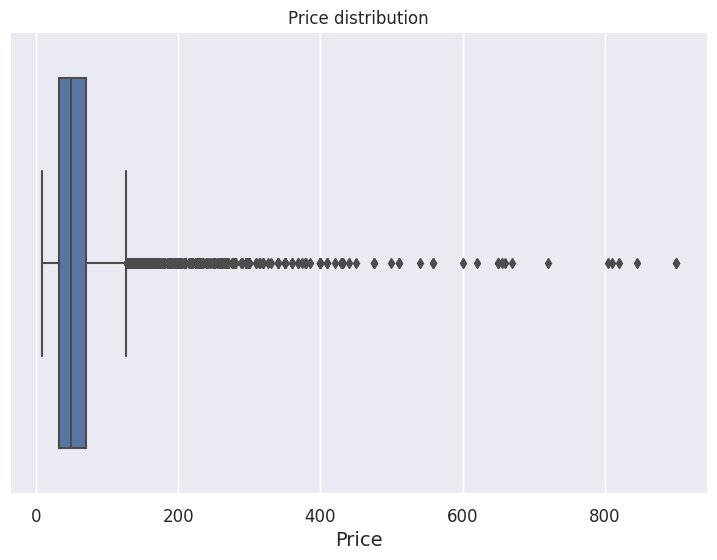

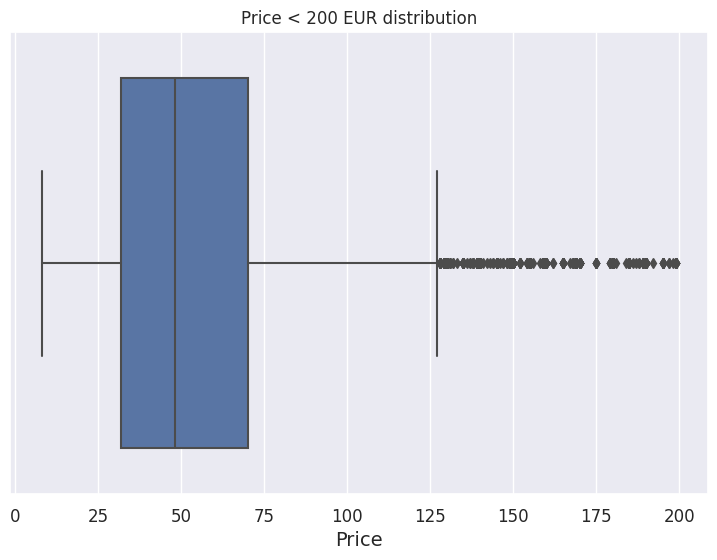

In [2]:
data = pd.read_csv('data/train_airbnb_berlin.xls')

sns.boxplot(x='Price', data=data)
plt.title('Price distribution')
plt.show()

plt.title('Price < 200 EUR distribution')
sns.boxplot(x='Price', data=data[data['Price'] < 200])
plt.show()

In [3]:
def split_train_test_stratify_regression(data: pd.DataFrame, test_size=0.3, random_state=None):
    data.replace('*', np.nan,inplace=True)
    data.dropna(subset=['Price'], inplace=True)
    data['Price Range'] = pd.cut(x=data['Price'], bins=[0,25,50,75,100,125,150,200,1000], labels=["price" + str(i) for i in range(0, 8)])

    # Convert dates
    data[['Host Since','First Review','Last Review']] = data[['Host Since','First Review','Last Review']].apply(pd.to_datetime)
    reference_date = datetime.strptime('2022-10-31', '%Y-%m-%d')
    data['Host Since'] = (reference_date - data['Host Since'] ).dt.days
    data['First Review'] = (reference_date - data['First Review'] ).dt.days
    data['Last Review'] = (reference_date - data['Last Review']).dt.days

    train, test = train_test_split(data, test_size=test_size, stratify=data['Price Range'], random_state=random_state)
    train.drop(columns=['Price Range'], inplace=True)
    test.drop(columns=['Price Range'], inplace=True)
    return train, test

In [4]:
train, test = split_train_test_stratify_regression(data, random_state=42)

## Data Analysis

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10978 entries, 8193 to 2557
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Listing ID             10978 non-null  float64
 1   Listing Name           0 non-null      float64
 2   Host ID                10978 non-null  float64
 3   Host Name              10961 non-null  object 
 4   Host Since             10961 non-null  float64
 5   Host Response Time     6004 non-null   object 
 6   Host Response Rate     5873 non-null   object 
 7   Is Superhost           10959 non-null  object 
 8   neighbourhood          10835 non-null  object 
 9   Neighborhood Group     10978 non-null  object 
 10  City                   10945 non-null  object 
 11  Postal Code            10206 non-null  object 
 12  Country Code           10978 non-null  object 
 13  Country                10978 non-null  object 
 14  Latitude               10978 non-null  float64
 15  

In [6]:
cols = ['Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Min Nights']
train[cols] = train[cols].astype('float')
test[cols] = test[cols].astype('float')

,Missing Ratio %
Listing Name,100.000000
Square Feet,98.169065
Host Response Rate,46.502095
Host Response Time,45.308799
Checkin Rating,19.156495
Location Rating,19.147386
Value Rating,19.147386
Communication Rating,19.138277
Cleanliness Rating,19.138277
Accuracy Rating,19.138277


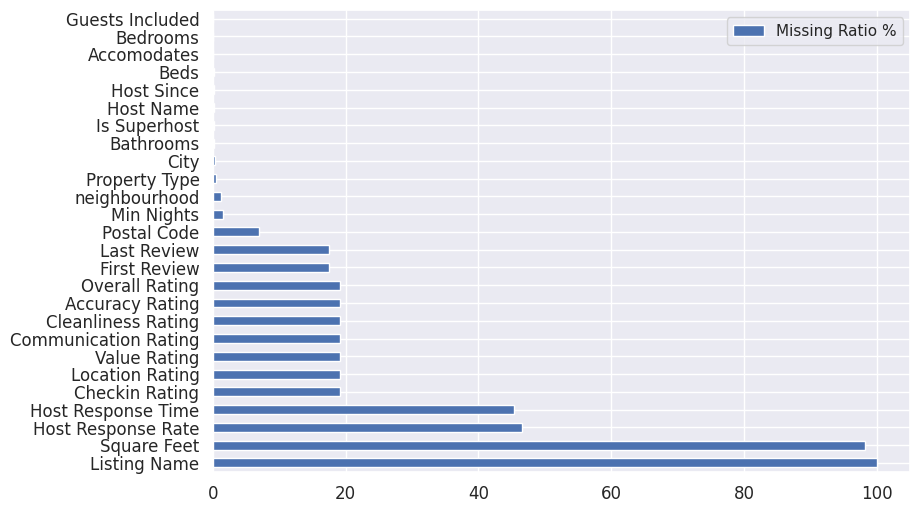

In [7]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        display(missing_data)
        missing_data.plot(kind = "barh")
        # sns.barplot(missing_data, x = "Missing Ratio %", y= missing_data.index, label= missing_data["Missing Ratio %"])
        plt.show()
    else:
        print('No NAs found')

plot_nas(train)

<AxesSubplot: xlabel='count', ylabel='Property Type'>

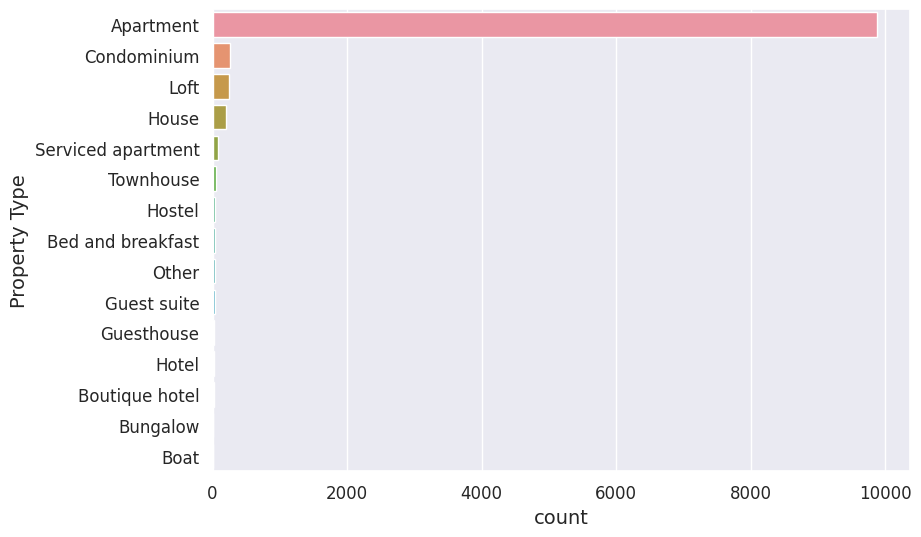

In [8]:
counts = train['Property Type'].value_counts(ascending=False)
sns.countplot(y=train["Property Type"], order=counts.index)

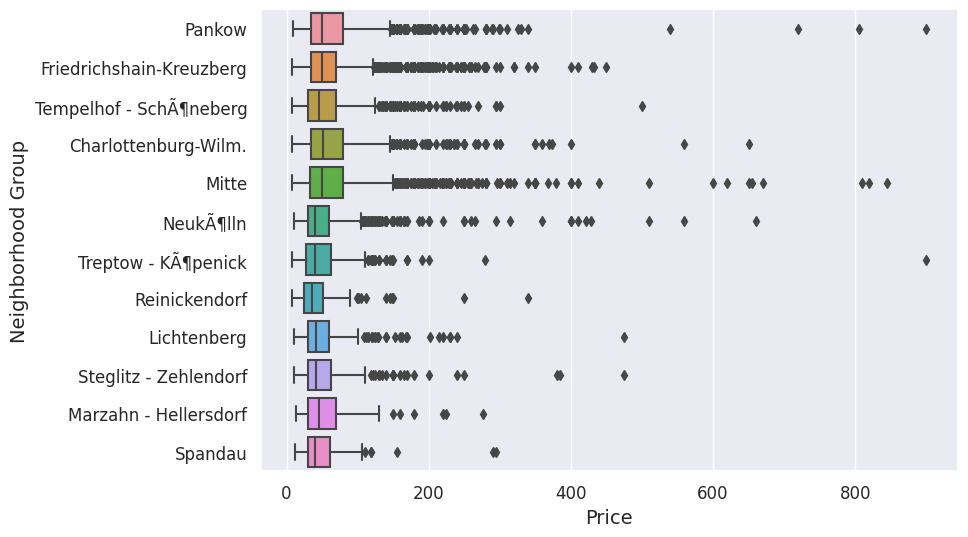

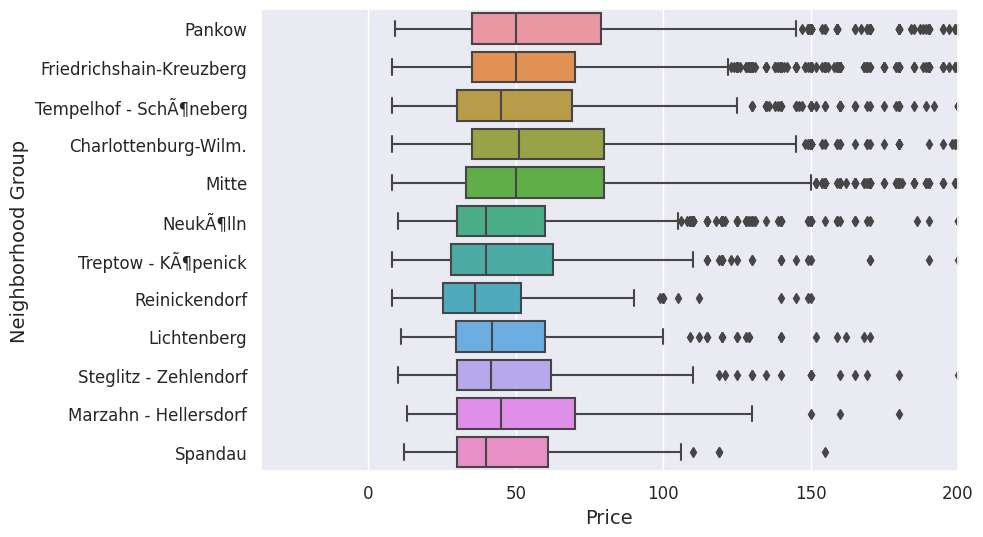

In [9]:
sns.boxplot(x='Price', y='Neighborhood Group', data=data)
plt.show()

sns.boxplot(x='Price', y='Neighborhood Group', data=data)
plt.xlim(plt.xlim()[0], 200)
plt.show()

In [10]:
def check_categorical_correlation(col1, col2):
    ndf = pd.crosstab(index=train[col1], columns=train[col2])
    chi2, p, dof, expected = chi2_contingency(ndf)
    print(f'Columns {col1}, {col2}')
    print(f'P-value: {p:.2g}')
    if p < 0.05:
        print('High correlation')
    print()

check_categorical_correlation('Neighborhood Group', 'Postal Code')
check_categorical_correlation('Neighborhood Group', 'neighbourhood')

Columns Neighborhood Group, Postal Code
P-value: 0
High correlation

Columns Neighborhood Group, neighbourhood
P-value: 0
High correlation



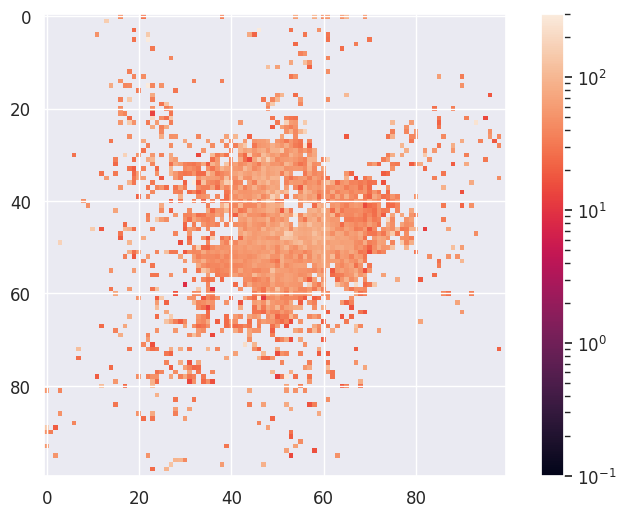

In [11]:
N = 100
lat, lon = np.meshgrid(np.linspace(train['Latitude'].min(),  train['Latitude'].max(),  N),
                       np.linspace(train['Longitude'].min(), train['Longitude'].max(), N))

mean_price = np.empty_like(lat)
for i in range(mean_price.shape[0]-1):
    for j in range(mean_price.shape[1]-1):
        mask_lat = (lat[i, j] <= train['Latitude']) & (train['Latitude'] < lat[i+1, j+1])
        mask_lon = (lon[i, j] <= train['Longitude']) & (train['Longitude'] < lon[i+1, j+1])
        mean_price[i, j] = np.mean(train['Price'][mask_lat & mask_lon])

plt.imshow(mean_price, norm=LogNorm(vmin=0.1, vmax=300))
plt.colorbar()

In [12]:
pd.DataFrame({'mean': train.groupby('Neighborhood Group')['Price'].mean(),
              'std': train.groupby('Neighborhood Group')['Price'].std(),
              'count': train['Neighborhood Group'].value_counts()}).sort_values(['std'])

,mean,std,count
Reinickendorf,44.503546,29.834693,141
Treptow - KÃ¶penick,49.363934,33.230980,305
Lichtenberg,51.839674,40.244333,368
Marzahn - Hellersdorf,57.044944,41.959372,89
NeukÃ¶lln,50.192833,42.283939,1758
Friedrichshain-Kreuzberg,60.659486,42.638127,2646
Tempelhof - SchÃ¶neberg,56.574728,44.022318,736
Charlottenburg-Wilm.,68.726415,52.742742,742
Pankow,66.006257,54.082027,1758
Steglitz - Zehlendorf,56.088670,55.545468,203


In [13]:
pd.DataFrame({'mean': train.groupby('neighbourhood')['Price'].mean(),
              'std': train.groupby('neighbourhood')['Price'].std(),
              'count': train['neighbourhood'].value_counts()}).sort_values(['std'])

,mean,std,count
Dahlem,55.800000,16.691981,10
Karow,41.571429,17.952318,7
Karlshorst,44.866667,18.964092,30
Reinickendorf,37.657895,19.300123,76
Friedrichsfelde,45.000000,20.194059,41
...,...,...,...
Wilhelmstadt,84.363636,74.812128,11
Tiergarten,91.081081,80.051825,74
WeiÃensee,60.920290,80.244613,138
Nikolassee,80.142857,115.148638,14


<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

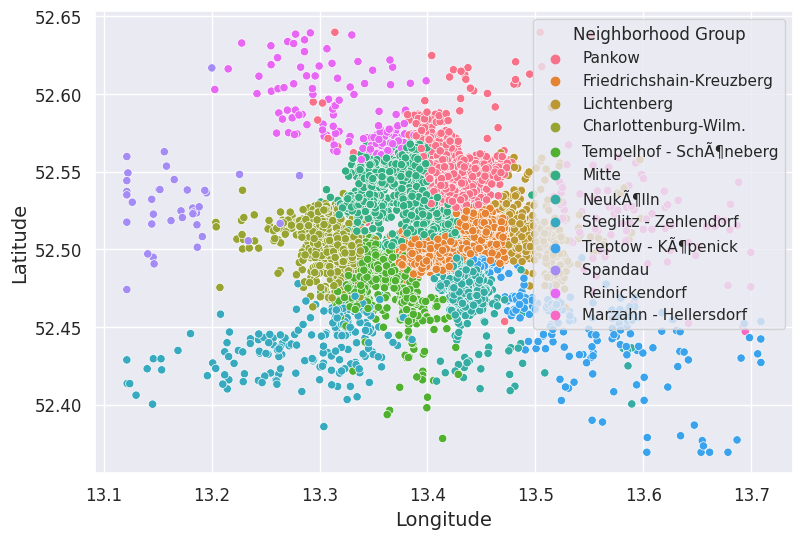

In [14]:
sns.scatterplot(x='Longitude', y='Latitude', hue='Neighborhood Group', data=train)

In [15]:
review_cols = ['First Review', 'Last Review', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating']

review_counts = train[review_cols].isnull().value_counts().to_frame()
review_counts.columns = ['count']
review_counts['proportion'] = review_counts['count'] / review_counts['count'].sum()

print('Distribution of missing data (False = not missing, True = missing)')
review_counts

Distribution of missing data (False = not missing, True = missing)


count  \
First Review Last Review Overall Rating Accuracy Rating Cleanliness Rating Checkin Rating Communication Rating Location Rating Value Rating          
False        False       False          False           False              False          False                False           False          8875   
True         True        True           True            True               True           True                 True            True           1917   
False        False       True           True            True               True           True                 True            True            179   
                         False          True            True               True           True                 True            True              5   
                                        False           False              True           False                False           False             1   
                                                                                                               True            True              1   

                                                                                                                                             proportion  
First Review Last Review Overall Rating Accuracy Rating Cleanliness Rating Checkin Rating Communication Rating Location Rating Value Rating              
False        False       False          False           False              False          False                False           False           0.808435  
True         True        True           True            True               True           True                 True            True            0.174622  
False        False       True           True            True               True           True                 True            True            0.016305  
                         False          True            True               True           True                 True            True            0.000455  
                                        False           False              True           False                False           False           0.000091  
                                                                                                               True            True            0.000091

In [16]:
train[['First Review', 'Last Review']]
train[review_cols + ['Price']].corr()['Price']

First Review            0.012915
Last Review            -0.108815
Overall Rating          0.045390
Accuracy Rating         0.022924
Cleanliness Rating      0.067258
Checkin Rating          0.018488
Communication Rating    0.034554
Location Rating         0.081628
Value Rating           -0.057576
Price                   1.000000
Name: Price, dtype: float64

In [17]:
train[['Latitude', 'Longitude', 'Location Rating']].corr()

,Latitude,Longitude,Location Rating
Latitude,1.000000,-0.118353,0.008241
Longitude,-0.118353,1.000000,-0.029208
Location Rating,0.008241,-0.029208,1.000000


In [18]:
train[review_cols + ['Price']].corr()['Overall Rating']

First Review           -0.064379
Last Review            -0.107606
Overall Rating          1.000000
Accuracy Rating         0.599791
Cleanliness Rating      0.646806
Checkin Rating          0.407283
Communication Rating    0.475722
Location Rating         0.340559
Value Rating            0.610374
Price                   0.045390
Name: Overall Rating, dtype: float64

Given that the column Overall Rating is correlated with the other ratings, and the fact that 18% of their values are missing, we chose to keep only the Overall Rating.

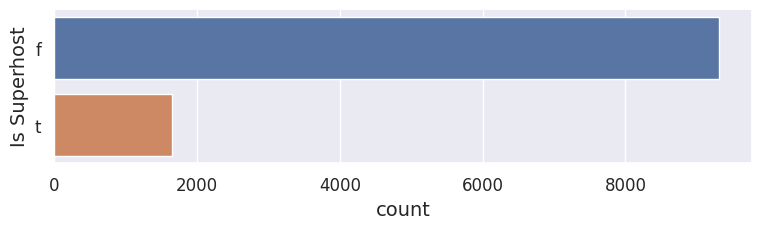

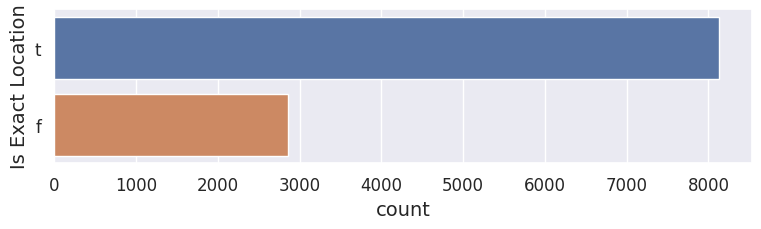

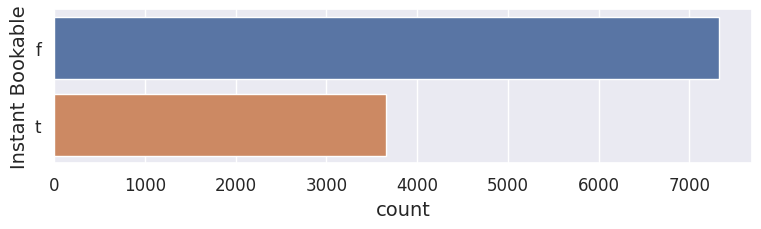

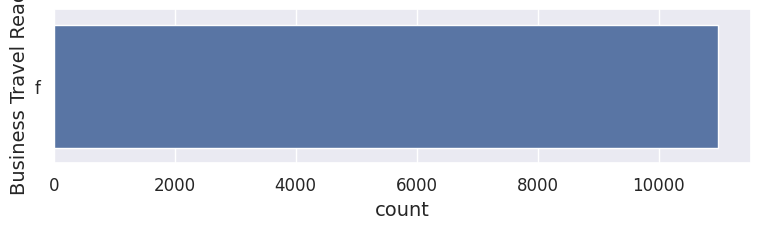

In [19]:
for col in ['Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Business Travel Ready']:
    counts = train[col].value_counts(ascending=False)
    plt.figure(figsize=(9, 2))
    sns.countplot(y=train[col], order=counts.index)
    plt.show()

Text(0.5, 1.0, 'Outliers for numeric features (after normalization)')

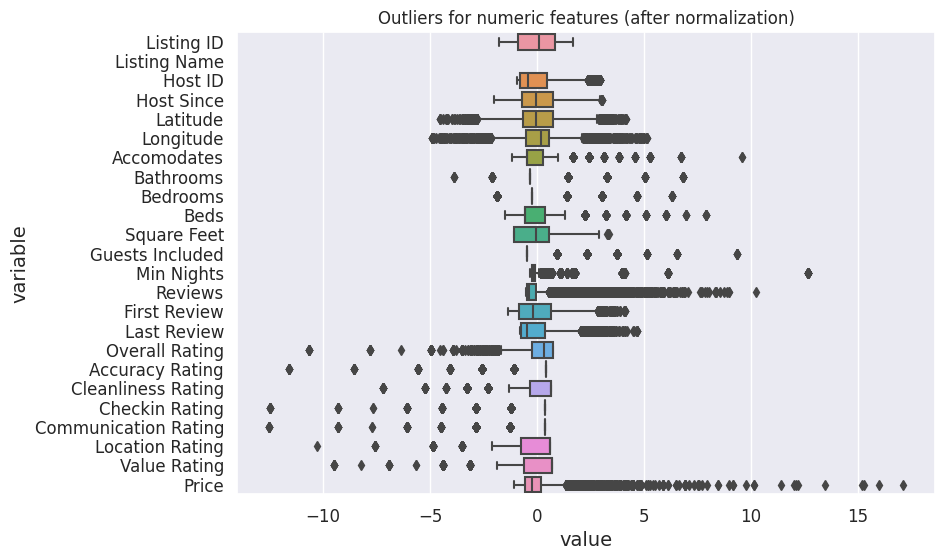

In [20]:
numeric = train.select_dtypes(include=['int', 'float'])
numeric = (numeric - numeric.mean()) / numeric.std()
sns.boxplot(x='value', y='variable', data=numeric.melt(value_vars=numeric.columns))
plt.title('Outliers for numeric features (after normalization)')

# Preprocessing

In [21]:
columns_to_keep = [
    # Keep as-is
    'Host Since', 'Latitude', 'Longitude', 'Accomodates', 'Bathrooms', 'Bedrooms',
    'Beds', 'Guests Included', 'Min Nights', 'Reviews',
    'First Review', 'Last Review', 'Overall Rating',

    # One-hot encoding
    'Neighborhood Group', 'Property Type',

    # Ordinal encoding
    'Room Type',

    # Convert to  bool
    'Is Superhost', 'Instant Bookable', 'Is Exact Location',
]

def transform_lat_lon(df):
    berlin=[52.520008,13.404954]
    latlon = pd.Series(tuple(zip(df.Latitude, df.Longitude)), index=df.index)
    df['to_berlin'] = latlon.apply(lambda row: haversine(berlin, row))
    return df

column_selector = FunctionTransformer(lambda df: df[columns_to_keep])

column_preprocessor = make_column_transformer(
    (
        OneHotEncoder(drop=None, min_frequency=0.01),
        ['Neighborhood Group', 'Property Type']
    ),
    (
        OrdinalEncoder(categories=[['Shared room', 'Private room', 'Entire home/apt']]),
        ['Room Type']
    ),
    (
        FunctionTransformer(lambda df: (df == 't').astype('int'), feature_names_out='one-to-one'),
        ['Is Superhost', 'Instant Bookable', 'Is Exact Location']
    ),
    (
        FunctionTransformer(transform_lat_lon, feature_names_out=lambda *_: ['Latitude', 'Longitude', 'to_berlin']),
        ['Latitude', 'Longitude']
    ),
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [22]:
def preprocess(pipeline, train, test):
    def to_df(values):
        return pd.DataFrame(values, columns=pipeline_preprocessing[1].get_feature_names_out())
    train_transformed = pipeline.fit_transform(train)
    test_transformed = pipeline.transform(test)
    return to_df(train_transformed), to_df(test_transformed)

pipeline_preprocessing = Pipeline(
    [
        ('column selector', column_selector),
        ('column encoder/preprocessor', column_preprocessor),
        ('imputer', IterativeImputer(sample_posterior=True, random_state=42, verbose=1)),
        ('scaler', RobustScaler()),
    ],
    verbose=True,
)

X_train_transformed, X_test_transformed = preprocess(pipeline_preprocessing, train, test)
y_train = train['Price']
y_test = test['Price']
X_train_transformed.head()

[Pipeline] ... (step 1 of 4) Processing column selector, total=   0.0s
[Pipeline]  (step 2 of 4) Processing column encoder/preprocessor, total=   0.2s
[IterativeImputer] Completing matrix with shape (10978, 34)
[Pipeline] ........... (step 3 of 4) Processing imputer, total=  29.5s
[Pipeline] ............ (step 4 of 4) Processing scaler, total=   0.0s
[IterativeImputer] Completing matrix with shape (4705, 34)


,Neighborhood Group_Charlottenburg-Wilm.,Neighborhood Group_Friedrichshain-Kreuzberg,Neighborhood Group_Lichtenberg,Neighborhood Group_Mitte,Neighborhood Group_NeukÃ¶lln,Neighborhood Group_Pankow,Neighborhood Group_Reinickendorf,Neighborhood Group_Steglitz - Zehlendorf,Neighborhood Group_Tempelhof - SchÃ¶neberg,Neighborhood Group_Treptow - KÃ¶penick,Neighborhood Group_infrequent_sklearn,Property Type_Apartment,Property Type_Condominium,Property Type_House,Property Type_Loft,Property Type_infrequent_sklearn,Room Type,Is Superhost,Instant Bookable,Is Exact Location,Latitude,Longitude,to_berlin,Host Since,Accomodates,Bathrooms,Bedrooms,Beds,Guests Included,Min Nights,Reviews,First Review,Last Review,Overall Rating
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.0,0.975969,0.565255,0.255464,0.381996,4.0,0.5,2.0,2.0,1.0,0.000000,9.6250,1.169899,-0.190557,0.100000
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.139392,0.089920,-0.781230,1.391325,0.0,0.0,0.0,1.0,0.0,-10.024503,-0.3125,3.408524,1.072064,-2.670505
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.430047,-0.401620,-0.310329,0.642257,0.0,0.5,0.0,0.0,0.0,1.500000,0.3750,0.306181,-0.003403,0.100000
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.036418,0.719994,-0.048635,-0.035914,2.0,0.0,1.0,1.0,1.0,-1.000000,-0.1875,-0.671321,-0.166738,-0.700000
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-0.110851,-1.938200,1.397532,-0.760728,-1.0,0.0,0.0,0.0,0.0,-1.000000,0.3750,-0.005172,-0.137814,0.100000


In [23]:
def eval_model(name, model, verbose=False, cv=5):
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print(f'RMSE ({name}): {-scores.mean():.2f}')

In [24]:
models = [
    RandomForestRegressor(random_state=42),
    KNeighborsRegressor(),
    SVR(),
    GradientBoostingRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    XGBRegressor(random_state=42),
]

for model in models:
    eval_model(model.__class__.__name__, model)

RMSE (RandomForestRegressor): 39.95
RMSE (KNeighborsRegressor): 42.30
RMSE (SVR): 42.32
RMSE (GradientBoostingRegressor): 38.90
RMSE (AdaBoostRegressor): 72.37
RMSE (XGBRegressor): 41.27


In [25]:
def grid_search(name, model, params, verbose=False, cv=5):
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error', verbose=3, n_jobs=-1)
    grid_search.fit(X_train_transformed, y_train)

    clear_output()
    display()
    print(f'[{name}]')
    print(f'best RMSE: {-grid_search.best_score_:.2f}')
    print(f'best hyperparams: {grid_search.best_params_}')
    return grid_search

In [26]:
grid_search_random_forest = grid_search('RandomForestRegressor', RandomForestRegressor(), params={
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2', 1.0],
    'min_samples_split': [2, 5],
})

[RandomForestRegressor]
best RMSE: 38.45
best hyperparams: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}


In [27]:
grid_search_gradient_boosting = grid_search('GradientBoostingRegressor', GradientBoostingRegressor(), params={
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.2, 0.1, 0.05],
    'max_depth': [2, 3, 5],
})

[GradientBoostingRegressor]
best RMSE: 38.57
best hyperparams: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}


## PCA

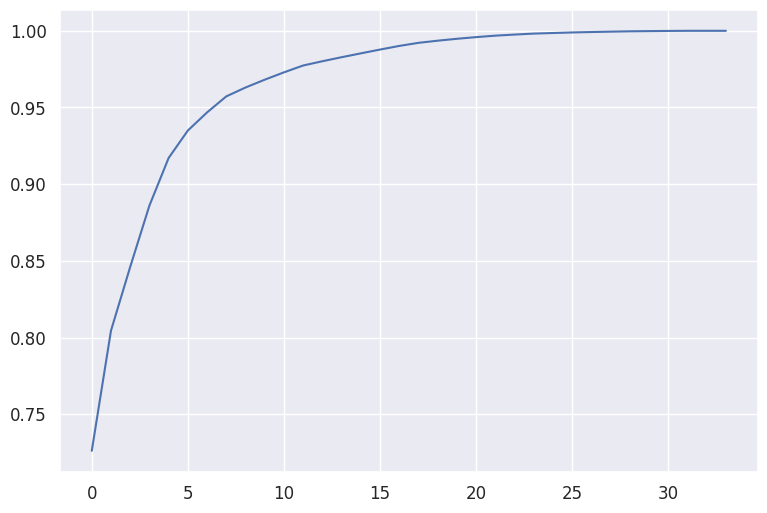

In [28]:
pca = PCA(random_state=42)
pca.fit(X_train_transformed)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [29]:
models = [
    RandomForestRegressor(random_state=42),
    KNeighborsRegressor(),
    SVR(),
    GradientBoostingRegressor(random_state=42),
    AdaBoostRegressor(random_state=42),
    XGBRegressor(random_state=42),
]

# PCA with enough components to explain 99% of the variance
pca99 = PCA(0.99)
for model in models:
    eval_model(model.__class__.__name__, make_pipeline(pca99, model))

RMSE (RandomForestRegressor): 41.20
RMSE (KNeighborsRegressor): 43.00
RMSE (SVR): 42.53
RMSE (GradientBoostingRegressor): 40.60
RMSE (AdaBoostRegressor): 79.59
RMSE (XGBRegressor): 42.04


# Testing on the Test set

In [31]:
model = RandomForestRegressor(max_depth=20, max_features='log2', min_samples_split=2, n_estimators=200, random_state=42)
model.fit(X_train_transformed, y_train)
y_test_pred = model.predict(X_test_transformed)

score = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'RMSE: {score:.2f}')

RMSE: 36.90
